In [1]:
import numpy as np
import pandas as pd
from time import perf_counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
def random_search(distance_matrix):
    n = len(distance_matrix)
    solution = list(range(n))
    np.random.shuffle(solution)
    
    return solution[:(n//2)]

In [3]:
def calculate_euclidean_distance(node1, node2):
    return np.round(np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2))

In [4]:
def get_distance_matrix(df, costs=False):
    num_nodes = df.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        node1 = df.iloc[i]
        for j in range(i, num_nodes):
            node2 = df.iloc[j]
            distance = calculate_euclidean_distance(node1, node2)
            if costs:
                distance_matrix[i,j] = distance + node2['cost']
                distance_matrix[j,i] = distance + node1['cost']
            else:
                distance_matrix[i,j] = distance
                distance_matrix[j,i] = distance
    return distance_matrix

In [5]:
def get_candidate_moves(distance_matrix, costs):
    n = len(distance_matrix)
    candidate_moves = dict()
    
    for i in range(n):
        distances = [(j, distance_matrix[i][j] + costs[j]) for j in range(n) if i != j]
        distances.sort(key=lambda x: x[1])
        candidate_moves[i] = [j for j, _ in distances[:10]]
    
    return candidate_moves

In [6]:
def get_node_moves(solution, node_index, candidate):
    moves = list()
    n = len(solution)
    moves.append( (solution[node_index-1], candidate) )
    moves.append( (solution[(node_index+1)%n], candidate) )
    return moves

In [7]:
def get_edge_moves(solution, node_index, candidate_index):
    moves = list()
    n = len(solution)
    moves.append( ( (solution[node_index], solution[(node_index+1)%n]), (solution[candidate_index], solution[(candidate_index+1)%n]) ) )
    moves.append( ( (solution[node_index-1], solution[node_index]), (solution[candidate_index-1], solution[candidate_index]) ) )
    return moves

In [8]:
def compute_node_swap_delta(solution, swap, distance_matrix, costs):
    new_solution = solution[:]
    n = len(new_solution)

    solution_node, outer_node = swap
    solution_node_idx = new_solution.index(solution_node)
    prev_solution_node, next_solution_node = new_solution[solution_node_idx-1], new_solution[(solution_node_idx+1)%n]

    old_cost = distance_matrix[prev_solution_node][solution_node] + distance_matrix[solution_node][next_solution_node] + \
                costs[solution_node]
    new_cost = distance_matrix[prev_solution_node][outer_node] + distance_matrix[outer_node][next_solution_node] + \
                costs[outer_node]
    
    delta = old_cost - new_cost
    new_solution[solution_node_idx] = outer_node

    return delta, new_solution

In [9]:
def compute_edge_swap_delta(solution, swap, distance_matrix):
    (edge1_start, edge1_end), (edge2_start, edge2_end) = swap
    idx_edge1_start = solution.index(edge1_start)
    idx_edge2_start = solution.index(edge2_start)
    
    old_distance = distance_matrix[edge1_start][edge1_end] + distance_matrix[edge2_start][edge2_end]
    new_distance = distance_matrix[edge1_start][edge2_start] + distance_matrix[edge1_end][edge2_end]
    
    delta = old_distance - new_distance


    if idx_edge1_start < idx_edge2_start:
        new_solution = solution[:idx_edge1_start+1] + solution[idx_edge1_start+1:idx_edge2_start+1][::-1] + \
                       solution[idx_edge2_start+1:] 
    else:
        new_solution = solution[:idx_edge2_start+1] + solution[idx_edge2_start+1:idx_edge1_start+1][::-1] + \
                       solution[idx_edge1_start+1:]
    return delta, new_solution

In [10]:
def steepest_local_search(solution, distance_matrix, costs, candidate_moves):
    while True:
        best_delta, best_solution = 0, None
        
        for node_index, node in enumerate(solution):
            candidates = candidate_moves[node]
            for candidate in candidates:
                
                if candidate in solution:
                    candidate_index = solution.index(candidate)
                    if abs(node_index - candidate_index) <= 1:
                        continue
                    swaps = get_edge_moves(solution, node_index, candidate_index)
                    for swap in swaps:
                        delta, new_solution = compute_edge_swap_delta(solution, swap, distance_matrix)
                        if delta > best_delta:
                            best_delta = delta
                            best_solution = new_solution[:]
                    
                else:
                    swaps = get_node_moves(solution, node_index, candidate)
                    for swap in swaps:
                        delta, new_solution = compute_node_swap_delta(solution, swap, distance_matrix, costs)
                        if delta > best_delta:
                            best_delta = delta
                            best_solution = new_solution[:]
        
        if best_solution is not None:
            solution = best_solution[:]
            continue
        
        return solution

In [11]:
columns = ["Algorithm", "TSPA", "TSPB", "TSPC", "TSPD"]
cost_df = pd.DataFrame(columns=columns)
time_df = pd.DataFrame(columns=columns)
best_solutions = {}

instances = ['TSPA', 'TSPB', 'TSPC', 'TSPD']
path = "../data/"

algo_name = 'Steepest-CandidateMovesEdges-Random'
new_row = pd.DataFrame({columns[0]: algo_name}, index=[0])
cost_df = pd.concat([cost_df, new_row], ignore_index=True)
time_df = pd.concat([time_df, new_row], ignore_index=True)
best_solutions_tmp = {}

for instance in instances:
    file_name = f'{path}{instance}.csv'
    df = pd.read_csv(file_name, names=['x', 'y', 'cost'], sep=';')
    distance_matrix = get_distance_matrix(df)
    distance_matrix_with_costs = get_distance_matrix(df, True)
    costs = df.cost.values
    total_costs, solutions, times = list(), list(), list()
    candidate_moves = get_candidate_moves(distance_matrix, costs)
    print(algo_name, instance)
    for i in range(200):
        print(i)
        solution = random_search(distance_matrix_with_costs)
        start_time = perf_counter()
        solution = steepest_local_search(solution, distance_matrix, costs, candidate_moves)
        total_cost = sum(distance_matrix_with_costs[solution[i]][solution[i+1]] for i in range(len(solution) - 1))
        total_cost += distance_matrix_with_costs[solution[-1]][solution[0]]
        end_time = perf_counter()
        total_costs.append(total_cost)
        solutions.append(solution)
        times.append(round(end_time - start_time, 3))
    best_solution_idx = np.argmin(total_costs)
    best_solutions_tmp[file_name] = solutions[best_solution_idx]
    cost_df.at[cost_df.index[-1], instance] = f'{np.mean(total_costs)} ({np.min(total_costs)} - {np.max(total_costs)})'
    time_df.at[time_df.index[-1], instance] = f'{round(np.mean(times), 3)} ({np.min(times)} - {np.max(times)})'
    print(f'{np.mean(total_costs)} ({np.min(total_costs)} - {np.max(total_costs)})')
    print(f'{np.mean(times)} ({np.min(times)} - {np.max(times)})')
    print(solutions[best_solution_idx])
    display(cost_df)
    display(time_df)
best_solutions[algo_name] = best_solutions_tmp

Steepest-CandidateMovesEdges-Random TSPA
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
80856.86 (76709.0 - 85935.0)
1.4481950000000001 (1.205 - 2.451)
[81, 154, 133, 102, 144, 141, 87, 67, 24, 6, 156, 172, 66, 98, 190, 72, 94, 31, 111, 14, 80, 124, 8, 169, 95, 112, 135, 99, 101, 167, 126, 75, 189, 109, 119, 26, 92, 48, 106, 160, 11, 152, 1, 177, 41, 137,

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,80856.86 (76709.0 - 85935.0),NaN,NaN,NaN


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,1.448 (1.205 - 2.451),NaN,NaN,NaN


Steepest-CandidateMovesEdges-Random TSPB
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
73804.335 (69986.0 - 80091.0)
1.4762400000000002 (1.217 - 1.761)
[34, 183, 197, 31, 101, 42, 38, 103, 131, 24, 121, 179, 143, 122, 92, 127, 50, 152, 112, 154, 134, 25, 36, 194, 165, 37, 137, 88, 55, 153, 80, 157, 145, 79, 136, 73, 185, 181, 147, 159, 64, 129, 89, 58, 8

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,80856.86 (76709.0 - 85935.0),73804.335 (69986.0 - 80091.0),NaN,NaN


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,1.448 (1.205 - 2.451),1.476 (1.217 - 1.761),NaN,NaN


Steepest-CandidateMovesEdges-Random TSPC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
51680.02 (49141.0 - 54538.0)
1.4374200000000001 (1.203 - 1.788)
[31, 94, 98, 156, 172, 6, 66, 190, 72, 112, 5, 51, 135, 99, 101, 167, 45, 186, 127, 88, 153, 21, 194, 79, 87, 141, 144, 154, 81, 32, 62, 108, 15, 117, 53, 22, 55, 195, 138, 74, 163, 113, 181, 61, 71, 20, 6

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,80856.86 (76709.0 - 85935.0),73804.335 (69986.0 - 80091.0),51680.02 (49141.0 - 54538.0),NaN


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,1.448 (1.205 - 2.451),1.476 (1.217 - 1.761),1.437 (1.203 - 1.788),NaN


Steepest-CandidateMovesEdges-Random TSPD
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
48294.905 (45672.0 - 52381.0)
1.36358 (1.078 - 2.015)
[123, 154, 134, 25, 36, 88, 55, 4, 153, 80, 157, 145, 79, 136, 73, 29, 18, 132, 185, 189, 181, 147, 159, 64, 129, 89, 58, 171, 72, 114, 67, 156, 91, 51, 174, 140, 148, 141, 130, 142, 21, 192, 196, 117, 150, 162, 44,

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,80856.86 (76709.0 - 85935.0),73804.335 (69986.0 - 80091.0),51680.02 (49141.0 - 54538.0),48294.905 (45672.0 - 52381.0)


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,1.448 (1.205 - 2.451),1.476 (1.217 - 1.761),1.437 (1.203 - 1.788),1.364 (1.078 - 2.015)


In [12]:
cost_df.to_csv('costs.csv')

In [13]:
time_df.to_csv('times.csv')

In [14]:
display(cost_df)

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,80856.86 (76709.0 - 85935.0),73804.335 (69986.0 - 80091.0),51680.02 (49141.0 - 54538.0),48294.905 (45672.0 - 52381.0)


In [15]:
display(time_df)

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-CandidateMovesEdges-Random,1.448 (1.205 - 2.451),1.476 (1.217 - 1.761),1.437 (1.203 - 1.788),1.364 (1.078 - 2.015)


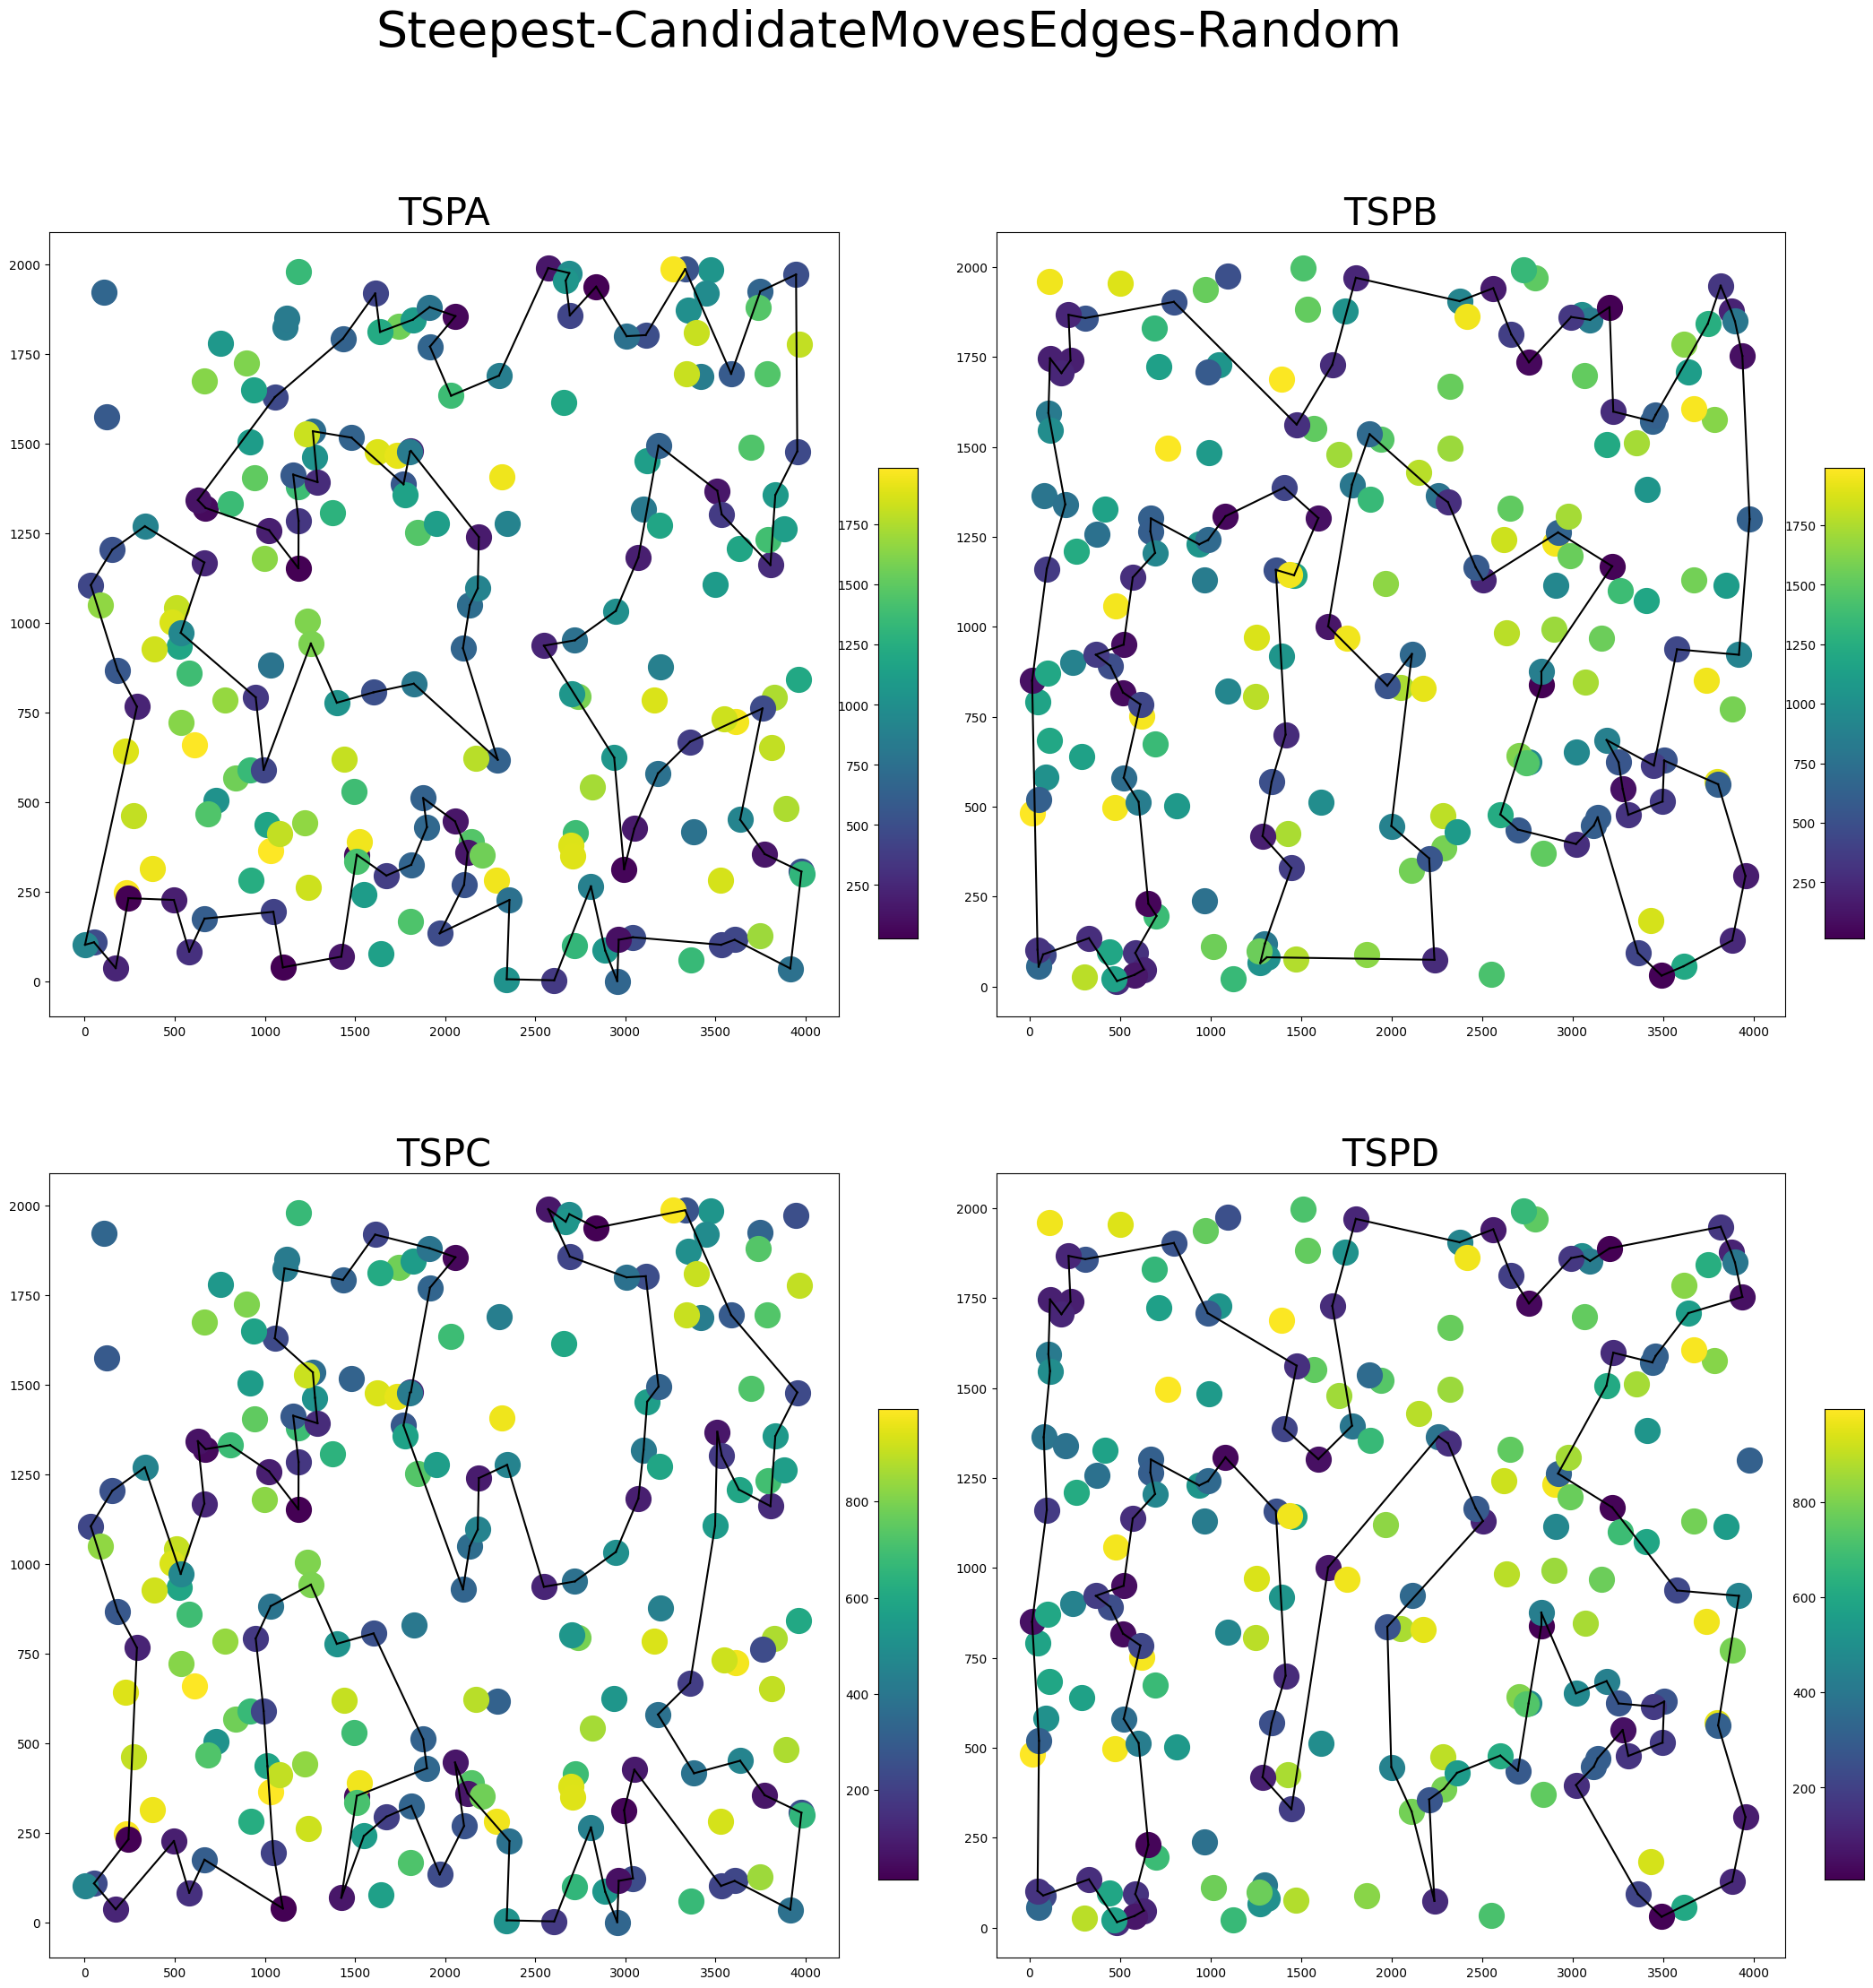

In [16]:
for algo in best_solutions:
    fig, ax = plt.subplots(2, 2, figsize=(25, 25))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(algo, fontsize=40)
    for instance in best_solutions[algo]:
        solution = best_solutions[algo][instance]
        df = pd.read_csv(instance, names=['x', 'y', 'cost'], sep=';')
        weights = df['cost']
        cmap = plt.cm.viridis
        norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
        ax[idx].set_title(instance.replace('../data/', '').replace('.csv', ''), fontsize=30)
        for i in range(len(df)):
            x, y, cost = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['cost']
            ax[idx].plot(x, y, "o", markersize=20, color=cmap(norm(cost)))
        for i in range(len(solution)-1):
            x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
            x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
            ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
        ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        
        axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)

        axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
        axins.xaxis.set_visible(False)
        
        idx += 1
        
    plt.savefig(f'./plots/{algo}.png', dpi=300)
    plt.show()